In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

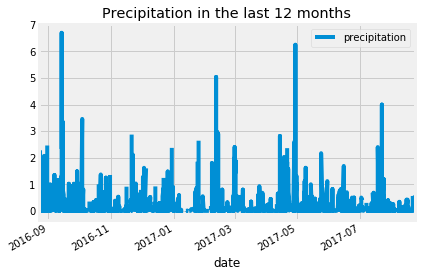

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12_months = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_12_months = last_12_months[0]

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.datetime.strptime(last_12_months, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
q1 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(q1, columns=['date', 'precipitation'])
precip_df['date'] = pd.to_datetime(precip_df['date'], format='%Y-%m-%d')
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df .plot(title="Precipitation in the last 12 months")
plt.legend(loc='best')
plt.savefig("Images/precipitation(12_months).png")
plt.show()


In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [30]:
# Design a query to show how many stations are available in this dataset?
num_available_stations = session.query(Measurement.station).distinct().count()
print(f" The Number of Stations Available In This Dataset: {num_available_stations} ")

 The Number of Stations Available In This Dataset: 9 


In [41]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print("The Most Active Stations:")
most_active_stations

The Most Active Stations:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

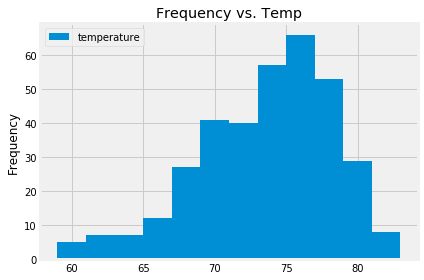

In [54]:
# Choose the station with the highest number of temperature observations.
highest_temp_obv = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
highest_temp_obv= highest_temp_obv[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_12month_observations = session.query(Measurement.tobs).filter(Measurement.date >= one_year_ago).filter(Measurement.station == most_temps_station).all()
last_12month_observations = pd.DataFrame(temperature_observations, columns=['temperature'])

# We need 12 bins since the observation is for twelve months
last_12month_observations.plot.hist(bins=12, title="Frequency vs. Temp")
plt.tight_layout()
plt.legend(loc="best")
plt.savefig("Images/TempvsFreq.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [59]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    select = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measur ement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [62]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

tmin = dt.date(2018, 4, 1)
tmax = dt.date(2018, 4, 15)
last_year = dt.timedelta(days=365)
tavg = (calc_temps((tmin-last_year), (tmax-last_year)))
print(tavg)

[(67.0, 74.47368421052632, 82.0)]


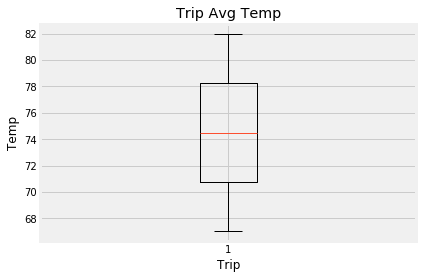

In [66]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
x = range(len(tavg))
ax.boxplot(tavg)
ax.set_title('Trip Avg Temp')
ax.set_ylabel("Temp")
ax.set_xlabel("Trip")
plt.show()

## Optional Challenge Assignment

In [6]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


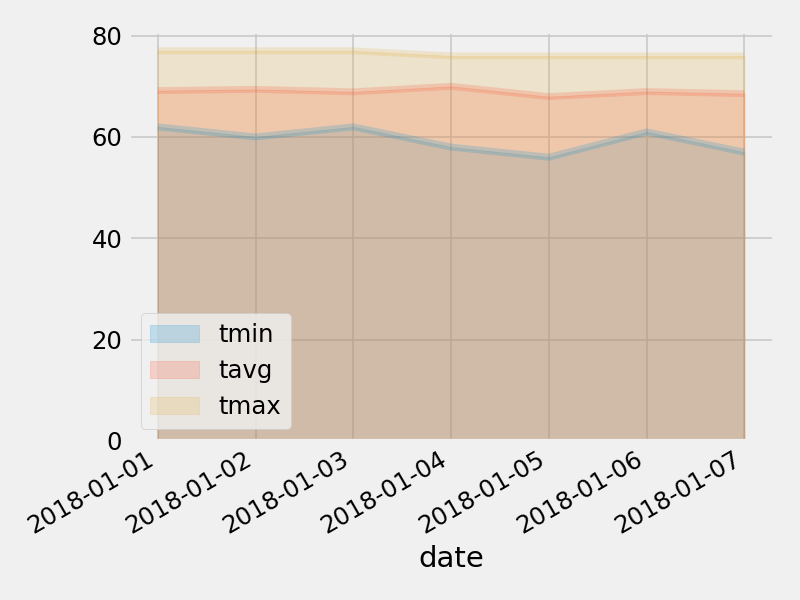

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
